In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score, balanced_accuracy_score, accuracy_score, recall_score, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PowerTransformer, RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from xgboost import XGBRegressor, plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from warnings import filterwarnings

filterwarnings('ignore')

In [2]:
def RMSE(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean() ** .5

def make_pipeline(categorical, numeric, model):

    numeric_transformer = Pipeline(steps=[
          ('scaler', PowerTransformer())
    ])

    categorical_transformer = Pipeline(steps=[
          ('encoder', OneHotEncoder())
    ])

    preprocessor = ColumnTransformer(
       transformers=[
        ('numeric', numeric_transformer, numeric),
        ('categorical', categorical_transformer, categorical),
    ])

    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    return pipeline


def fit_pipeline(pipeline, train_data, test_data):

    pipeline.fit(train_data.drop(TARGET, axis=1), train_data[TARGET])
    y_pred=pipeline.predict(test_data.drop(TARGET, axis=1))
    print(f"Model R-Square : {r2_score(test_data[TARGET],y_pred)*100:.2f}%")
    print("Model RMSE :", RMSE(test_data[TARGET],y_pred))

    return pipeline

In [3]:
def cross_val_best_model(model_list, X_train, y_train):

    # to feed the random state
    seed = 7
    # evaluate each model in turn
    results = []
    names = []
    scoring = 'neg_root_mean_squared_error'

    for name, model in model_list:
        kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

    # boxplot algorithm comparison
    fig = plt.figure(figsize=(11,6))
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

    return model_list

In [4]:
bike_data = pd.read_csv('SeoulBikeData.csv')
bike_data = bike_data.drop(bike_data[bike_data['Functioning Day'] == 'No'].index)

In [5]:
bike_data.head()

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [6]:
bike_data.describe()

,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.00000,8465.000000
mean,729.156999,11.507029,12.771057,58.147194,1.725883,1433.873479,3.944997,0.567868,0.14912,0.077685
std,642.351166,6.920899,12.104375,20.484839,1.034281,609.051229,13.242399,0.868245,1.12554,0.444063
min,2.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.00000,0.000000
25%,214.000000,6.000000,3.000000,42.000000,0.900000,935.000000,-5.100000,0.000000,0.00000,0.000000
50%,542.000000,12.000000,13.500000,57.000000,1.500000,1690.000000,4.700000,0.010000,0.00000,0.000000
75%,1084.000000,18.000000,22.700000,74.000000,2.300000,2000.000000,15.200000,0.930000,0.00000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.00000,8.800000


<Axes: >

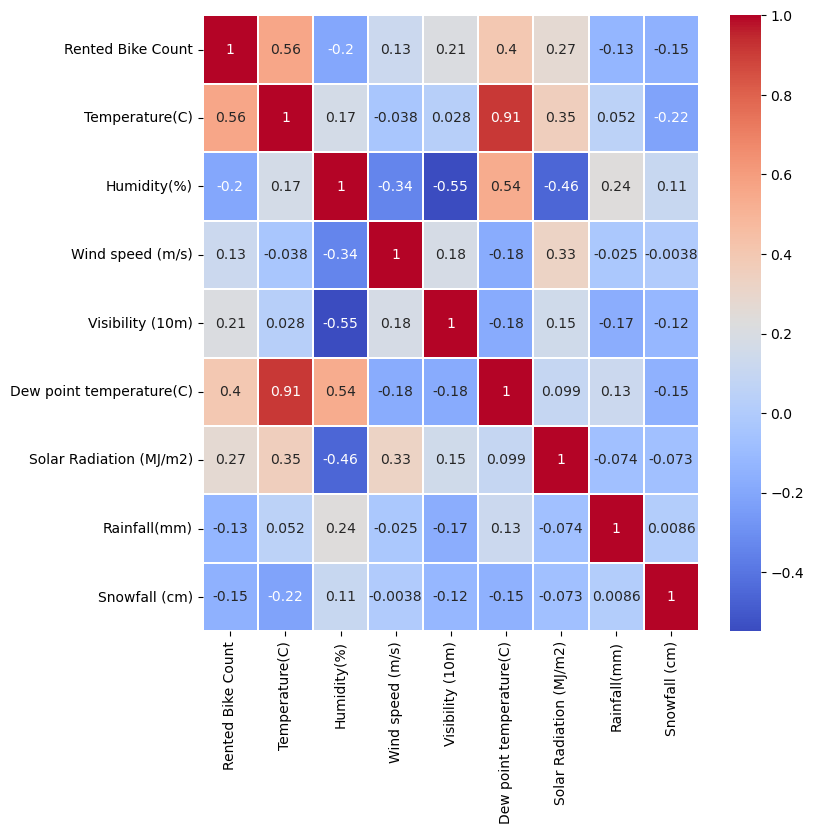

In [7]:
bike_data_corr= bike_data.drop(columns=['Hour', 'Date', 'Seasons', 'Holiday', 'Functioning Day']).corr()
plt.figure(figsize=(8,8))
sns.heatmap(bike_data_corr, cmap='coolwarm', linewidths=0.1, annot=True, linecolor='white')

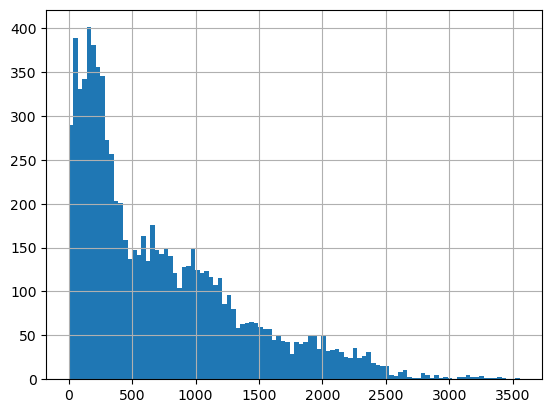

In [8]:
bike_data['Rented Bike Count'].hist(bins=100)
plt.show()

In [9]:
bike_data['Date'] = pd.to_datetime(bike_data.Date, format="%d/%m/%Y")
bike_data['Day of week'] = bike_data.Date.dt.day_of_week + 1
bike_data['Day of year'] = bike_data.Date.dt.day_of_year
bike_data['Month name'] = bike_data.Date.dt.month_name()
bike_data['Month'] = bike_data.Date.dt.month

In [10]:
bike_data['IsHoliday'] = (bike_data['Holiday'] == 'Holiday').astype('int32')

In [11]:
bike_data.head()

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Day of week,Day of year,Month name,Month,IsHoliday
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,5,335,December,12,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,5,335,December,12,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,5,335,December,12,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,5,335,December,12,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,5,335,December,12,0


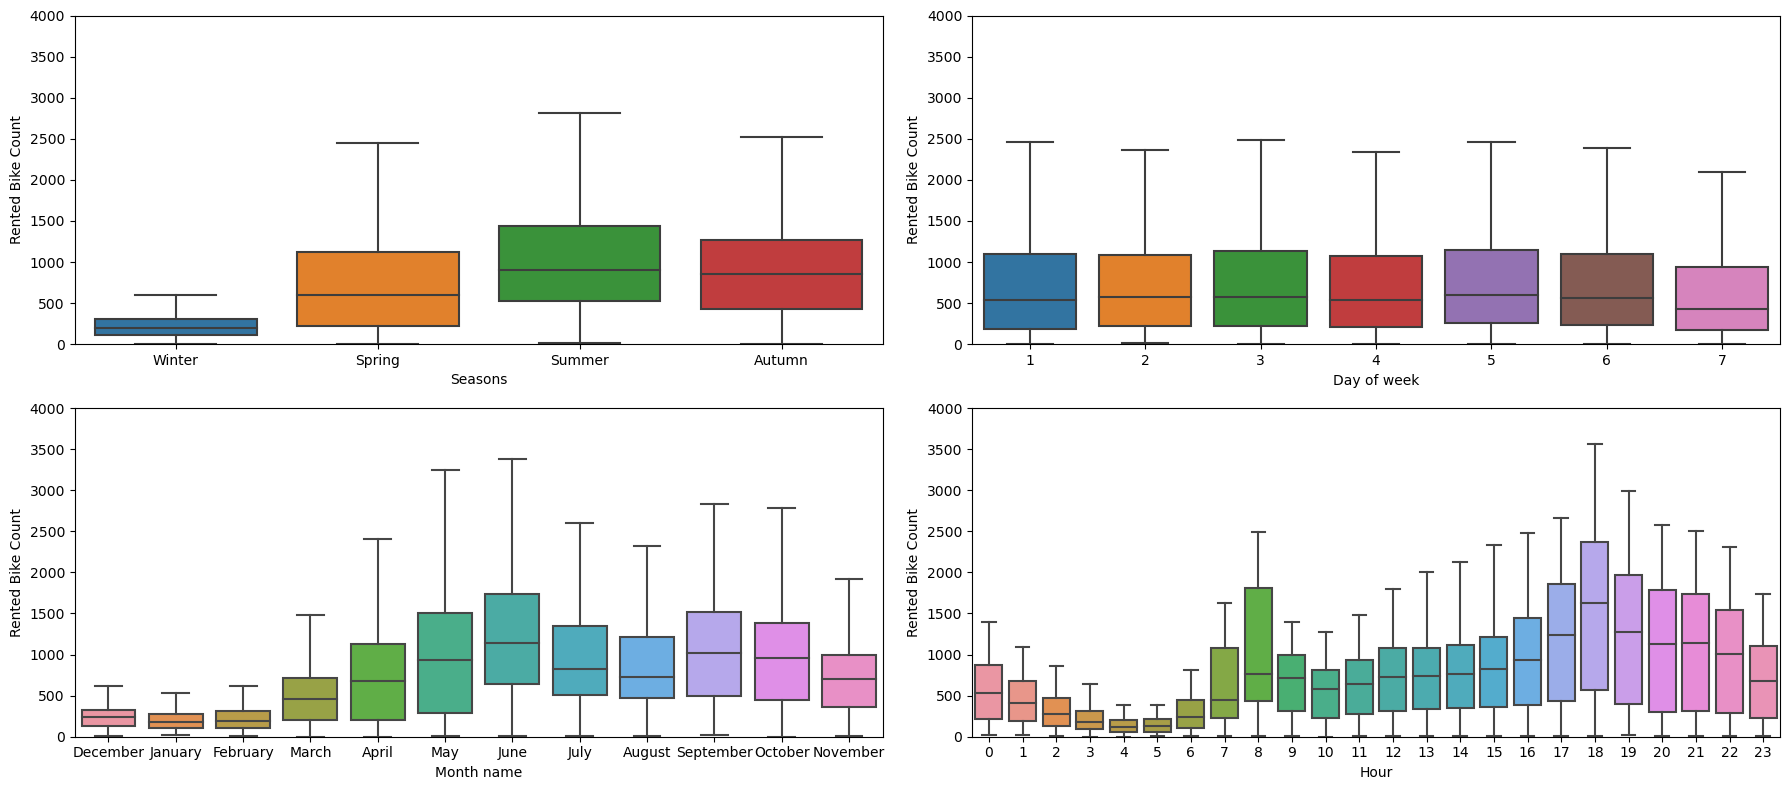

In [12]:
f, axs = plt.subplots(2, 2, figsize=(18, 8))

for col in ['Seasons', 'Month name', 'Day of week', 'Hour']:

    temp_axs = axs[int(col == 'Month name') + int(col == 'Hour'),
                   int(col == 'Day of week') + int(col == 'Hour')]
    sns.boxplot(data=bike_data, x=col, y='Rented Bike Count', showfliers = False, ax=temp_axs)
    temp_axs.set_ylim([0, 4000])

f.tight_layout()

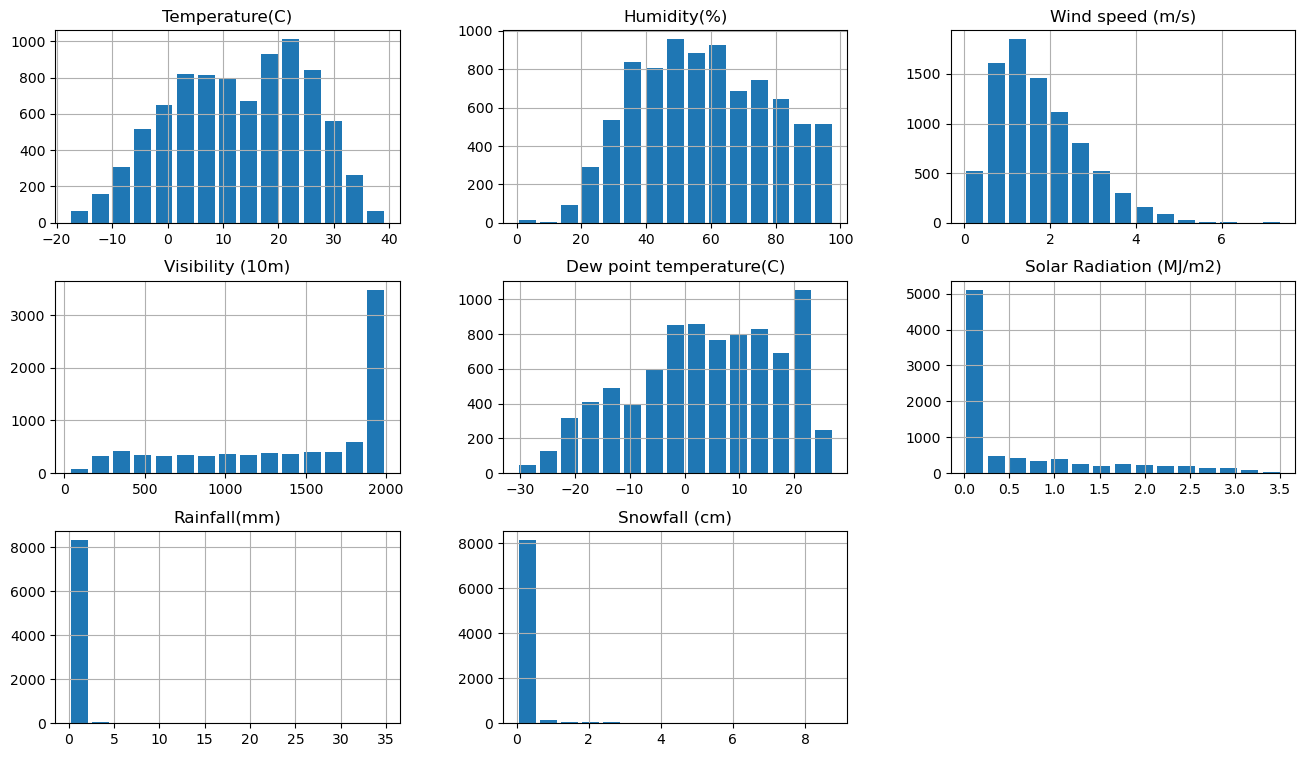

In [13]:
bike_data.drop(columns=['Rented Bike Count', 'Date', 'Hour', 'Day of week', 'Day of year', 'Month', 'IsHoliday']).hist(bins=15,  figsize=(16, 9), rwidth=0.8)
plt.show()

In [14]:
TARGET = 'Rented Bike Count'
categorical_columns = ['Day of year', 'Hour', 'Day of week', 'IsHoliday', 'Month']
numeric_columns = ['Temperature(C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Solar Radiation (MJ/m2)',
                   'Rainfall(mm)', 'Snowfall (cm)']

In [15]:
model_dict = {'LR' : LinearRegression(), 'Ridge' : Ridge(), 'LASSO' : Lasso(),
              'DTR' : DecisionTreeRegressor(), 'RF' : RandomForestRegressor(random_state=42),
              'XGB' : XGBRegressor(random_state=42)}

In [16]:
pipeline_list = []
for key in model_dict.keys():
        pipeline_list.append((key, make_pipeline(categorical_columns, numeric_columns, model_dict[key])))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(bike_data.drop(columns=['Rented Bike Count']),
                 bike_data['Rented Bike Count'], random_state=42, test_size=0.2)

LR: -317.522484 (6.913939)
Ridge: -316.997401 (6.856829)
LASSO: -334.403255 (7.695743)
DTR: -256.375659 (15.481674)
RF: -196.831713 (15.321489)
XGB: -178.538608 (7.967227)


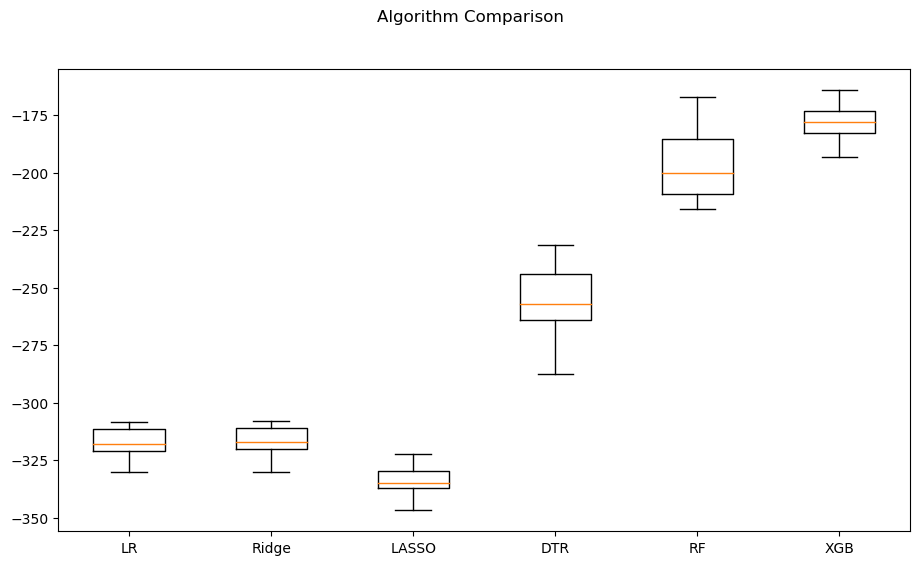

In [18]:
linear_models = cross_val_best_model(pipeline_list, bike_data.drop(columns=['Rented Bike Count']),
                                                                   bike_data['Rented Bike Count'])

In [19]:
tree_list = [('DTR', DecisionTreeRegressor()),
               ('RF', RandomForestRegressor(random_state=42)),
               ('XGB', XGBRegressor(random_state=42))]

DTR: -221.584863 (24.773831)
RF: -159.356374 (13.239323)
XGB: -145.395816 (10.864729)


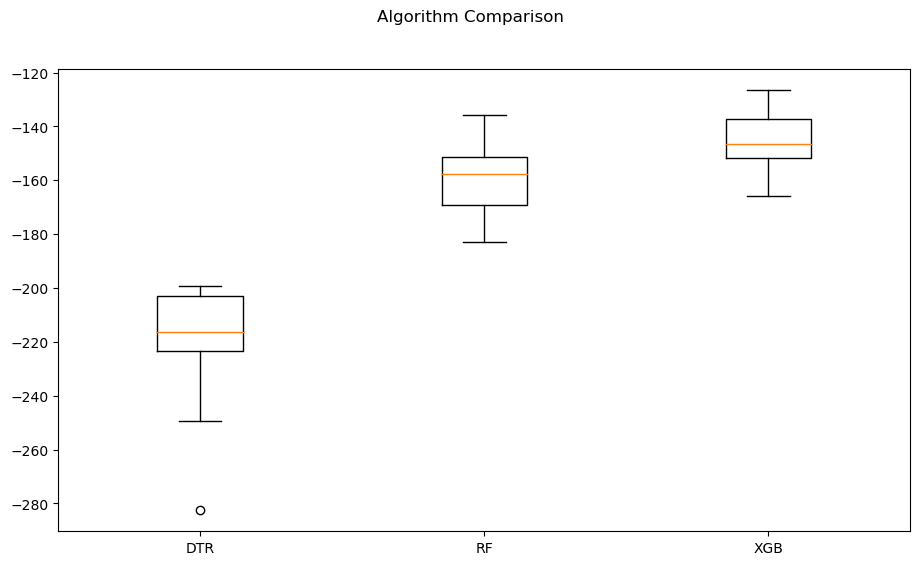

In [20]:
tree_models = cross_val_best_model(tree_list, bike_data.drop(columns=['Rented Bike Count', 'Date', 'Seasons',
                                                                            'Holiday',
                                                                                     'Functioning Day', 'Month name',
                                                                                     'Dew point temperature(C)']),
                                                             bike_data['Rented Bike Count'])

In [21]:
booster_van = fit_pipeline(XGBRegressor(), *train_test_split(bike_data.drop(columns=['Date', 'Seasons', 'Holiday',
                                                                                     'Functioning Day', 'Month name',
                                                                                     'Dew point temperature(C)']),
                                                               random_state=42, test_size=0.2))

Model R-Square : 93.48%
Model RMSE : 159.9591124307448


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

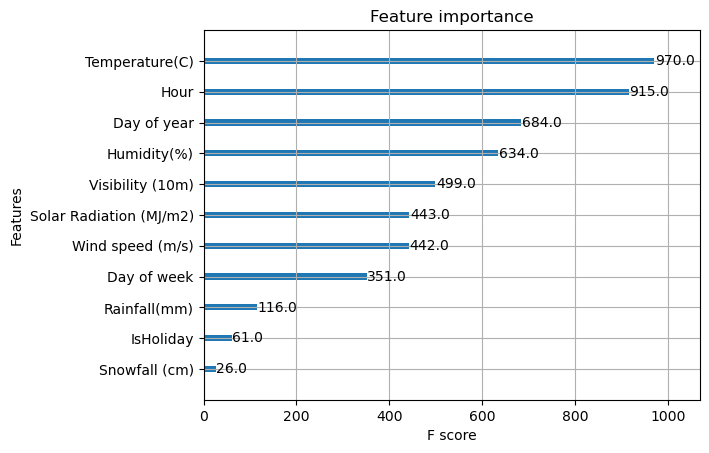

In [22]:
plot_importance(booster_van)

In [23]:
def year_change(data):

    for i in range(1, 111, 2):
        col_name = data.iloc[:,i].name[0:6]+'d'
        data[col_name] = data.iloc[:,i+1] - data.iloc[:,i]

    return data

In [24]:
def new_dataset():

    train_df = pd.read_csv('train.csv')
    data = pd.concat([train_df.loc[train_df['BANKR'] == 0].sample(n = 5000, random_state=12),
                         train_df.loc[train_df['BANKR'] == 1]], ignore_index=True)

    return data

In [25]:
def cross_val_best_model_clf(X_train, y_train, scr):

    # to feed the random state
    seed = 7

    # prepare models
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('DTR', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('RF', RandomForestClassifier(random_state = 42)))
    models.append(('XGB', XGBClassifier(random_state = 42)))

    # evaluate each model in turn
    results = []
    names = []
    scoring = scr

    for name, model in models:
        kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

    # boxplot algorithm comparison
    fig = plt.figure(figsize=(11,6))
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

    return models

In [26]:
train_df = pd.read_csv('train.csv')

<Axes: xlabel='BANKR'>

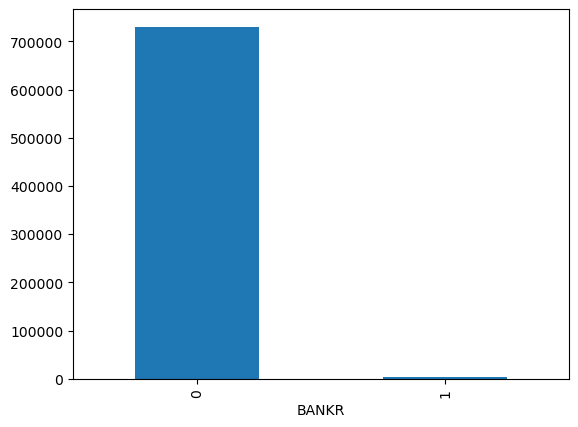

In [27]:
train_df['BANKR'].value_counts().plot.bar()

In [28]:
train_data5k = year_change(new_dataset())
X_train, X_test, y_train, y_test = train_test_split(train_data5k.drop(columns=['BANKR', 'ID_FIRM']),
                                                    train_data5k['BANKR'],
                                                    random_state=42, test_size=0.2)

LR: 0.745927 (0.012466)
LDA: 0.551970 (0.006671)
DTR: 0.783962 (0.012905)
NB: 0.550977 (0.017947)
RF: 0.848973 (0.014096)
XGB: 0.850422 (0.012225)


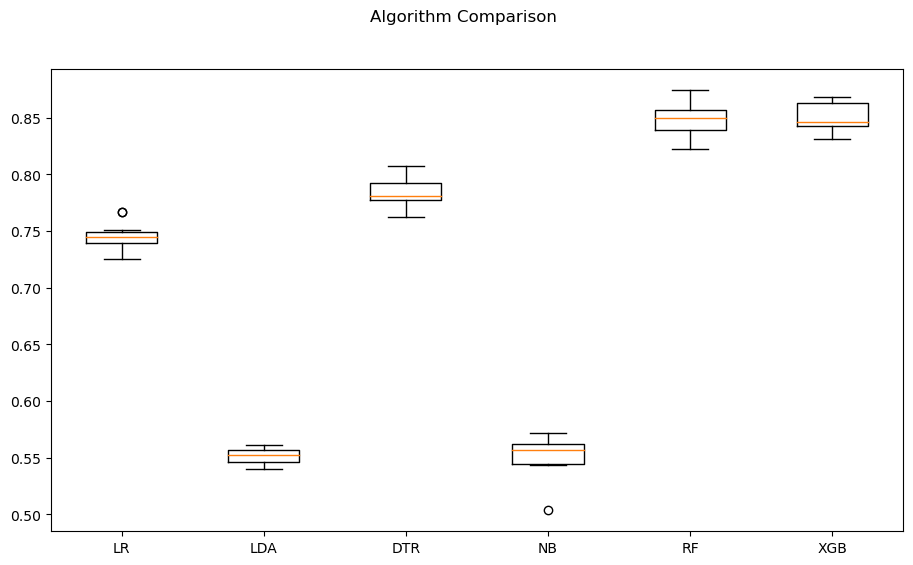

[('LR', LogisticRegression()),
 ('LDA', LinearDiscriminantAnalysis()),
 ('DTR', DecisionTreeClassifier()),
 ('NB', GaussianNB()),
 ('RF', RandomForestClassifier(random_state=42)),
 ('XGB',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, gamma=None,
                gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
                max_leaves=None, min_child_weight=None, missing=nan,
                monotone_constraints=None, n_estimators=100, n_jobs=None,
                num_parallel_tree=None, predictor=None, random_state=42,
                reg_alpha=None, reg_lambda=None, ...))]

In [29]:
cross_val_best_model_clf(train_data5k.drop(columns=['BANKR', 'ID_FIRM']), train_data5k['BANKR'], 'balanced_accuracy')

In [30]:
xgb_ens = XGBClassifier(random_state = 42)
xgb_ens.fit(X_train, y_train)
balanced_accuracy_score(y_test, xgb_ens.predict(X_test))

0.8516481739858666

In [31]:
rnd_forest = RandomForestClassifier(random_state = 42)
rnd_forest.fit(X_train, y_train)
balanced_accuracy_score(y_test, rnd_forest.predict(X_test))

0.8539261446034407

In [2]:
wine_data = pd.read_csv('wine-clustering.csv')

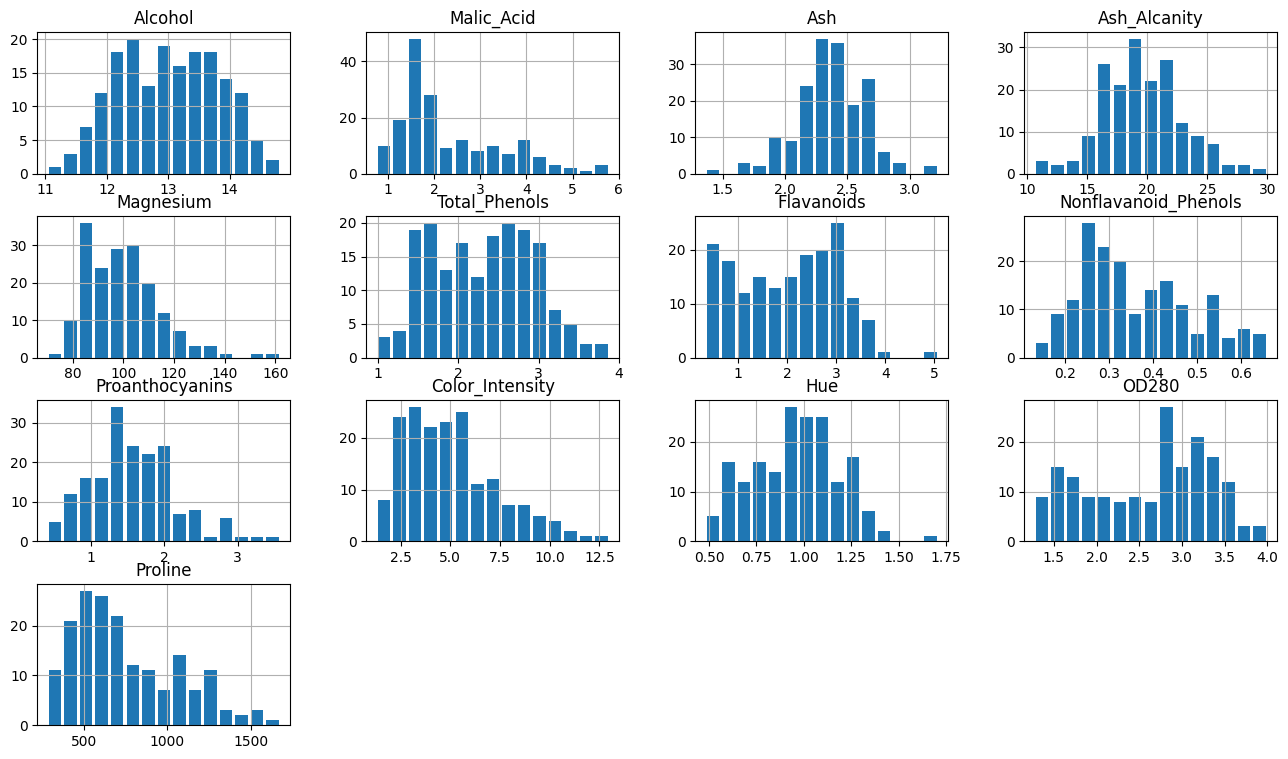

In [3]:
wine_data.hist(bins=15,  figsize=(16, 9), rwidth=0.8)
plt.show()

In [4]:
scaler = StandardScaler()
standartized_data = scaler.fit_transform(wine_data)

In [5]:
decomp = PCA(n_components=2)
decomp_data = decomp.fit_transform(wine_data)

In [6]:
decomp_stand_data = decomp.fit_transform(standartized_data)

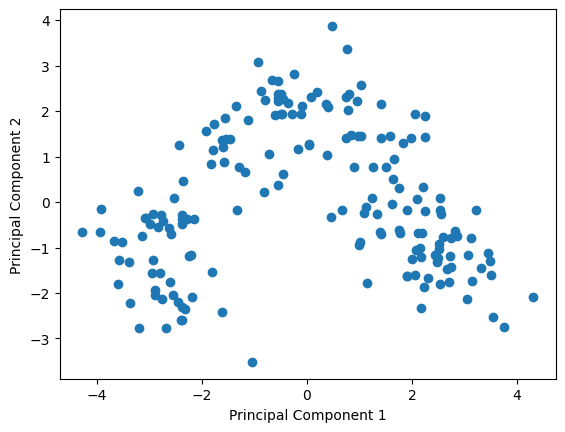

In [7]:
plt.scatter(decomp_stand_data[:, 0], decomp_stand_data[:, 1])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

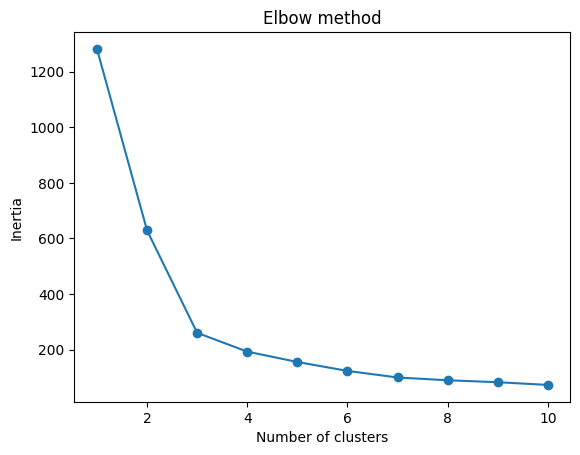

In [8]:
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(decomp_stand_data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

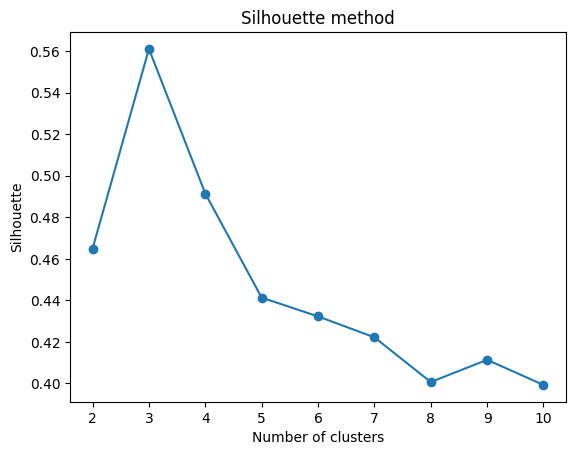

In [9]:
silhouette = []

for i in range(2,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(decomp_stand_data)
    silhouette.append(silhouette_score(decomp_stand_data, kmeans.labels_))

plt.plot(range(2,11), silhouette, marker='o')
plt.title('Silhouette method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')
plt.show()

In [10]:
clust_decomp_model = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(decomp_stand_data)

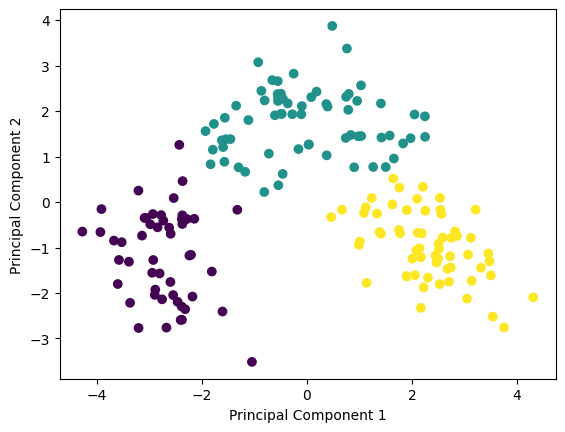

In [11]:
plt.scatter(decomp_stand_data[:, 0], decomp_stand_data[:, 1], c=clust_decomp_model.labels_)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [12]:
silhouette_score(decomp_stand_data, clust_decomp_model.labels_)

0.5601697480957203